In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm

import plotly.express as px
import seaborn as sns

import pandas as pd
import numpy as np

import os
from pathlib import Path

In [2]:
current_dir = Path.cwd()
print(f"Current working directory:", current_dir)

loss_calculation_folder = current_dir / "evaluation"
print("input files at",loss_calculation_folder)

output_dir= loss_calculation_folder / "output"
print("Outout directory for plots at", output_dir) 

Current working directory: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project
input files at /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation
Outout directory for plots at /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/output


In [3]:
scenario = ['PAK', 'RUS', 'HOA', 'URU', 'ALL']


df = {}
for s in scenario:
    filename = loss_calculation_folder / f"{s}-highestLosses.csv"  
    
    if filename.exists():
        try:
            df[s] = pd.read_csv(filename)
            print(f"✓ Loaded: {filename}")
        except Exception as e:
            print(f"× Error loading {filename}: {str(e)}")
    else:
        print(f"! File not found: {filename}")

✓ Loaded: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/PAK-highestLosses.csv
✓ Loaded: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/RUS-highestLosses.csv
✓ Loaded: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/HOA-highestLosses.csv
✓ Loaded: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/URU-highestLosses.csv
✓ Loaded: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/ALL-highestLosses.csv


Skipping PAK: no positive values to plot.


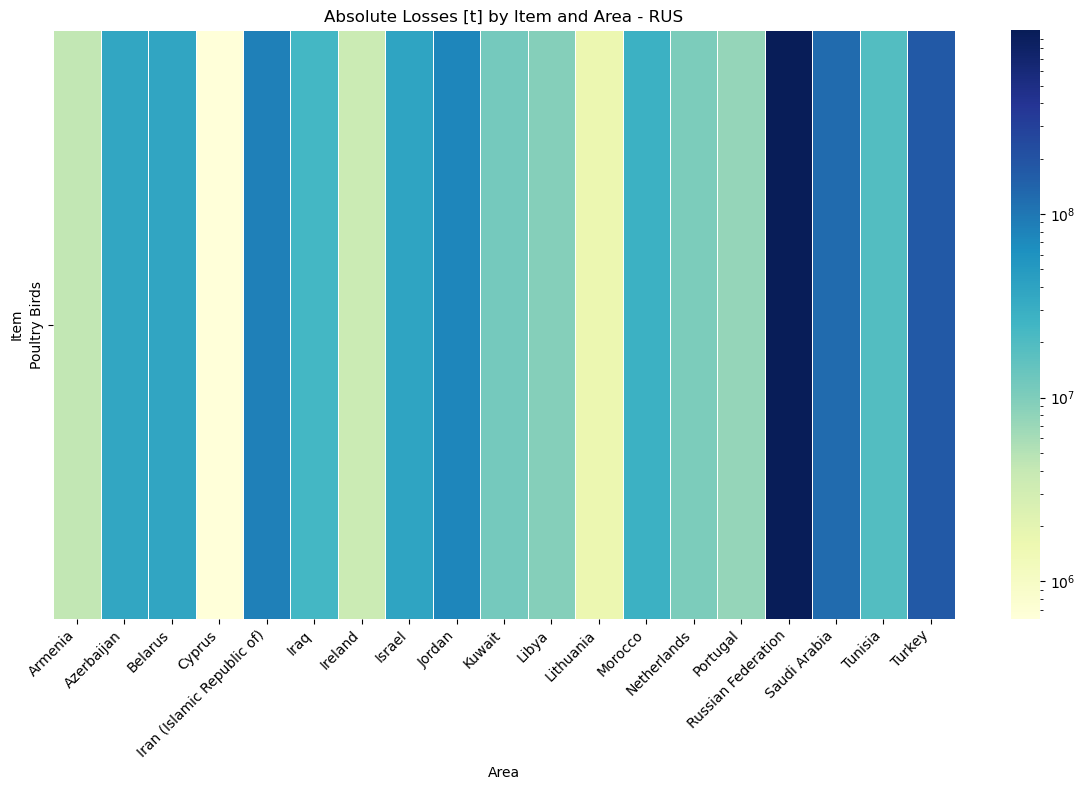

Skipping HOA: no positive values to plot.
Skipping URU: no positive values to plot.


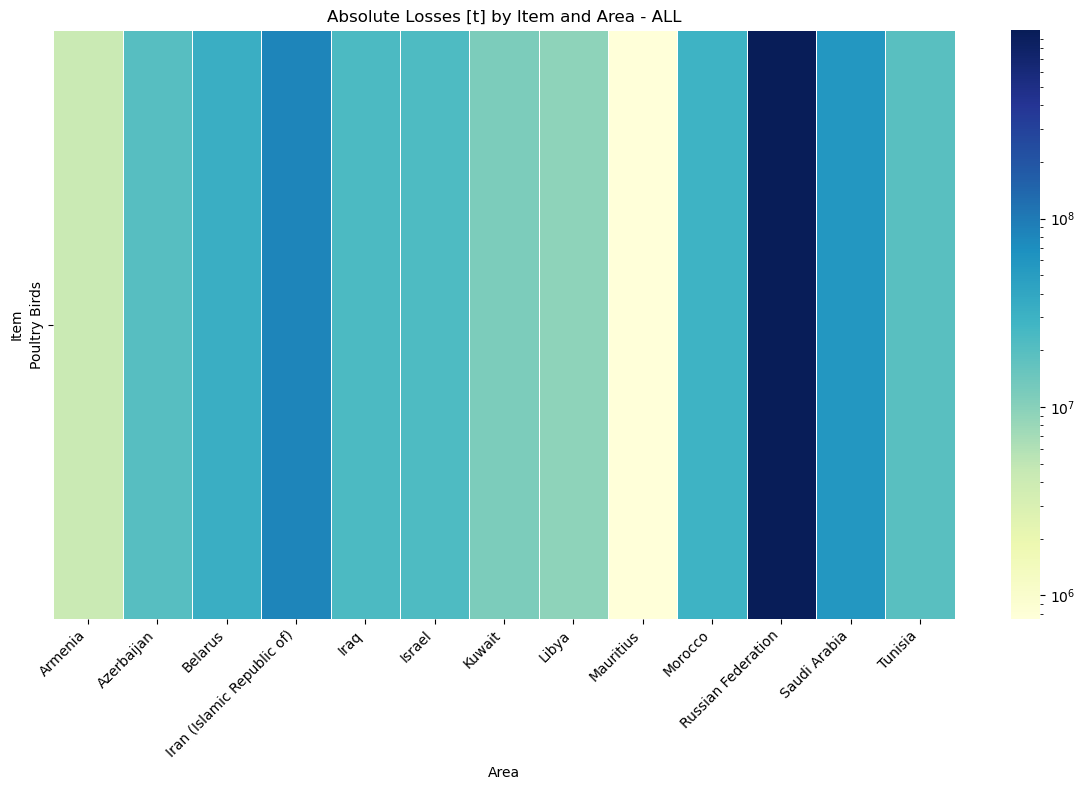

In [4]:
for s in scenario:
    pivot_table = df[s].pivot_table(
        index='item',
        columns='area',
        values='absolute_losses [t]',
        aggfunc='sum',
        fill_value=0
    )

    masked_data = pivot_table.replace(0, np.nan)
    positive_values = masked_data.values.flatten()
    positive_values = positive_values[~np.isnan(positive_values)]

    if len(positive_values) == 0:
        print(f"Skipping {s}: no positive values to plot.")
        continue

    vmin = positive_values.min()
    vmax = positive_values.max()

    cmap = sns.color_palette("YlGnBu", as_cmap=True)
    cmap.set_bad(color='white')

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        masked_data,
        cmap=cmap,
        norm=mcolors.LogNorm(vmin=vmin, vmax=vmax),
        linewidths=0.5
    )

    title = f"Absolute Losses [t] by Item and Area - {s}"
    plt.title(title)
    plt.xlabel("Area")
    plt.ylabel("Item")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    filename = f"{title.replace(' ', '_').replace('[t]', 't').replace('/', '-')}.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300)
    plt.show()

Skipping PAK: no positive values to plot.


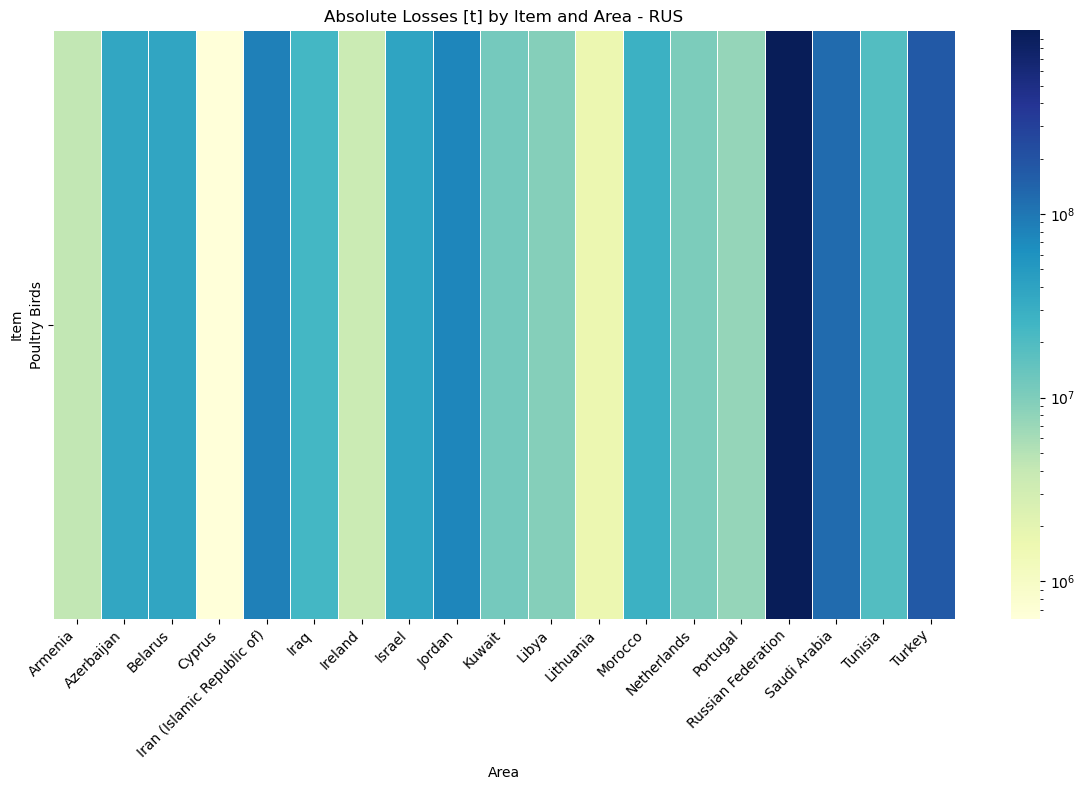

Skipping HOA: no positive values to plot.
Skipping URU: no positive values to plot.


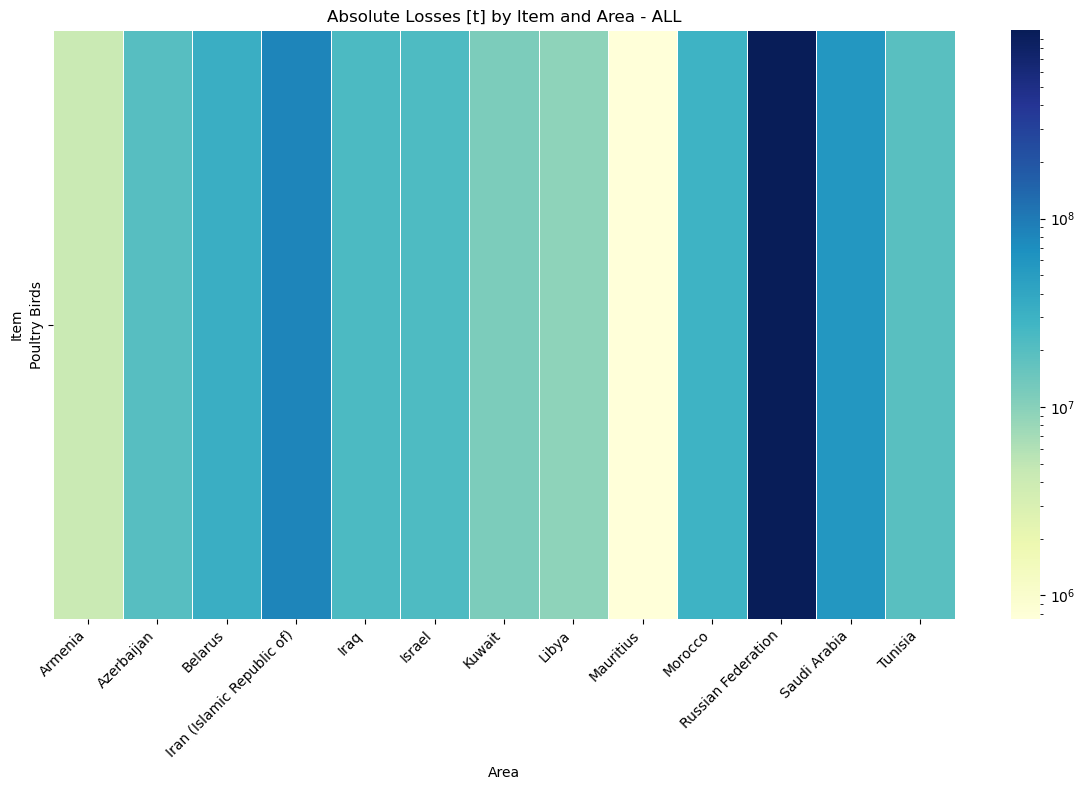

In [5]:
for s in scenario:
    pivot_table = df[s].pivot_table(
        index='item',
        columns='area',
        values='absolute_losses [t]',
        aggfunc='sum',
        fill_value=0
    )

    masked_data = pivot_table.replace(0, np.nan)
    positive_values = masked_data.values.flatten()
    positive_values = positive_values[~np.isnan(positive_values)]

    if len(positive_values) == 0:
        print(f"Skipping {s}: no positive values to plot.")
        continue

    vmin = positive_values.min()
    vmax = positive_values.max()

    cmap = sns.color_palette("YlGnBu", as_cmap=True)
    cmap.set_bad(color='white')

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        masked_data,
        cmap=cmap,
        norm=mcolors.LogNorm(vmin=vmin, vmax=vmax),
        linewidths=0.5
    )

    title = f"Absolute Losses [t] by Item and Area - {s}"
    plt.title(title)
    plt.xlabel("Area")
    plt.ylabel("Item")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    filename = f"{title.replace(' ', '_').replace('[t]', 't').replace('/', '-')}.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300)
    plt.show()

Skipping PAK: no positive values to plot.


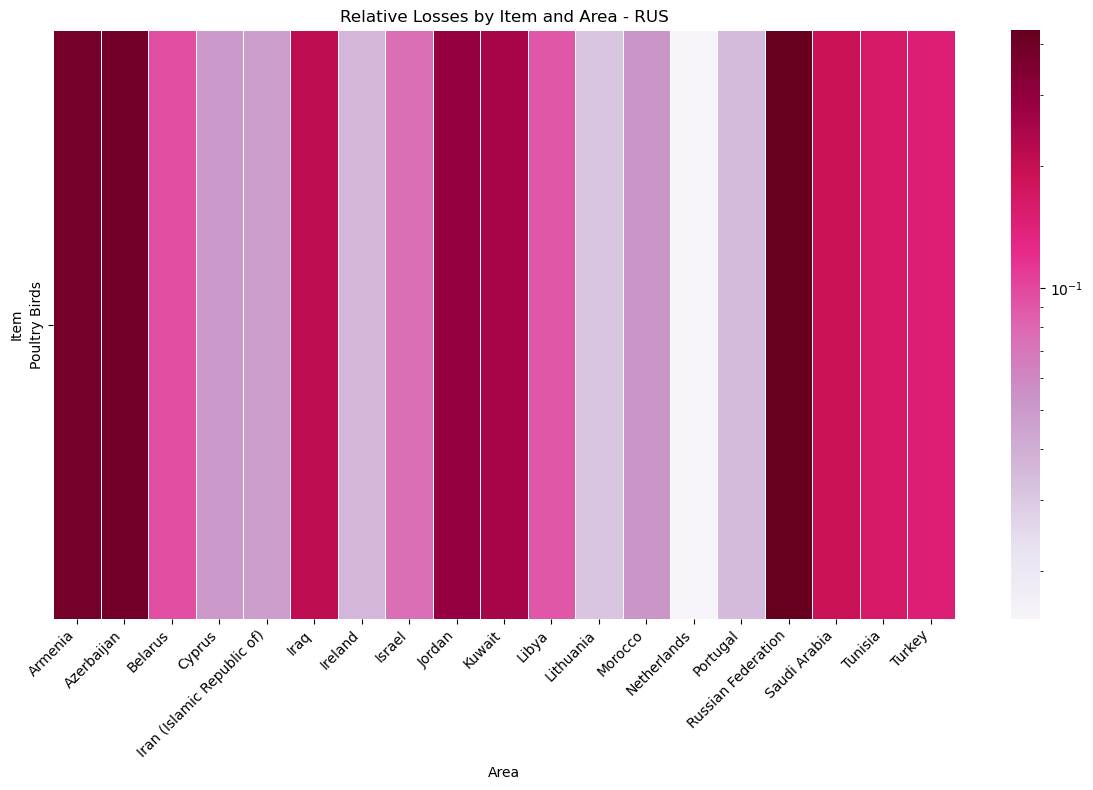

Skipping HOA: no positive values to plot.
Skipping URU: no positive values to plot.


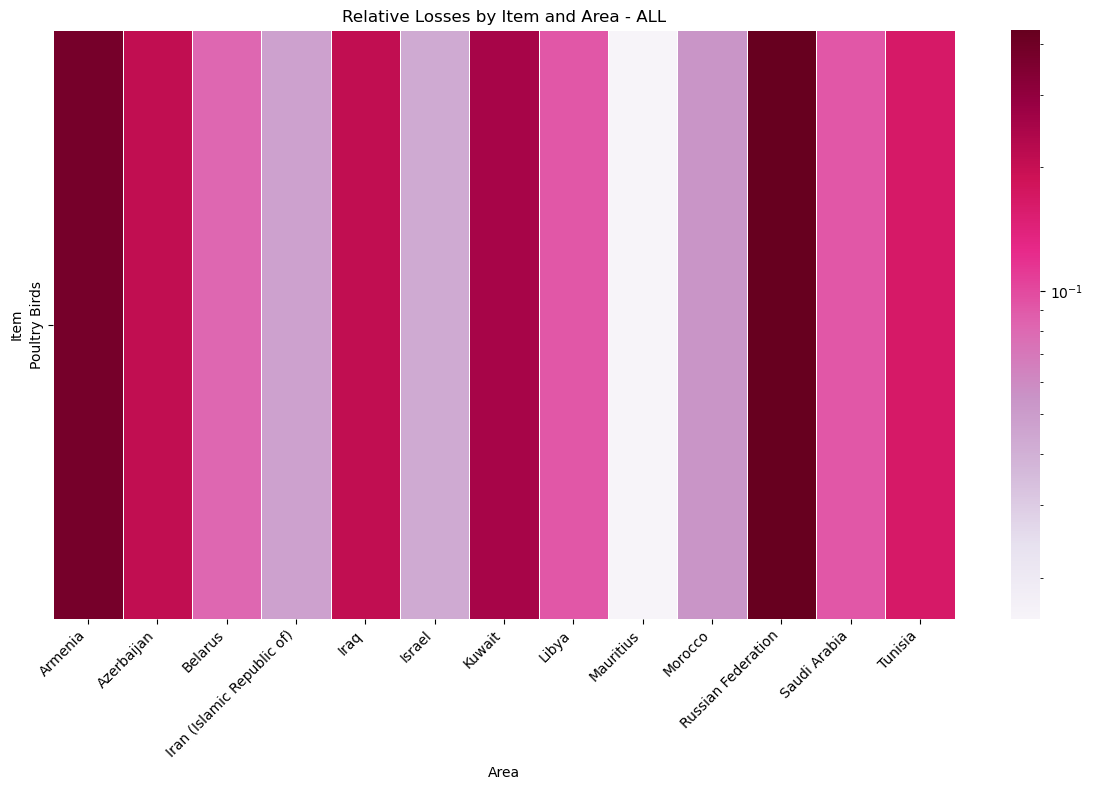

In [6]:
for s in scenario:
    pivot_table = df[s].pivot_table(
        index='item',
        columns='area',
        values='relative_losses',
        aggfunc='sum',
        fill_value=0
    )
    
    masked_data = pivot_table.replace(0, np.nan)
    positive_values = masked_data.values.flatten()
    positive_values = positive_values[~np.isnan(positive_values)]

    if len(positive_values) == 0:
        print(f"Skipping {s}: no positive values to plot.")
        continue  # skip to next scenario

    vmin = positive_values.min()
    vmax = positive_values.max()

    cmap = sns.color_palette("PuRd", as_cmap=True)
    cmap.set_bad(color='white')

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        masked_data,
        cmap=cmap,
        norm=mcolors.LogNorm(vmin=vmin, vmax=vmax),
        linewidths=0.5
    )
    plot_title = f"Relative Losses by Item and Area - {s}"
    plt.title(plot_title)
    plt.xlabel("Area")
    plt.ylabel("Item")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    filename = f"relative_losses_{s.replace(' ', '_')}.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=300)
    plt.show()

# Absolute Profits

In [7]:
df = {}
for s in scenario:
    filename = loss_calculation_folder / f"{s}-highestProfits.csv"  # Now works
    
    if filename.exists():
        try:
            df[s] = pd.read_csv(filename)
            print(f"✓ Loaded: {filename}")
        except Exception as e:
            print(f"× Error loading {filename}: {str(e)}")
    else:
        print(f"! File not found: {filename}")

✓ Loaded: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/PAK-highestProfits.csv
✓ Loaded: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/RUS-highestProfits.csv
✓ Loaded: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/HOA-highestProfits.csv
✓ Loaded: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/URU-highestProfits.csv
✓ Loaded: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/ALL-highestProfits.csv


Skipping PAK: no valid data to plot.
Scenario: RUS, vmin=691.86338030476, vmax=2128.591227110672


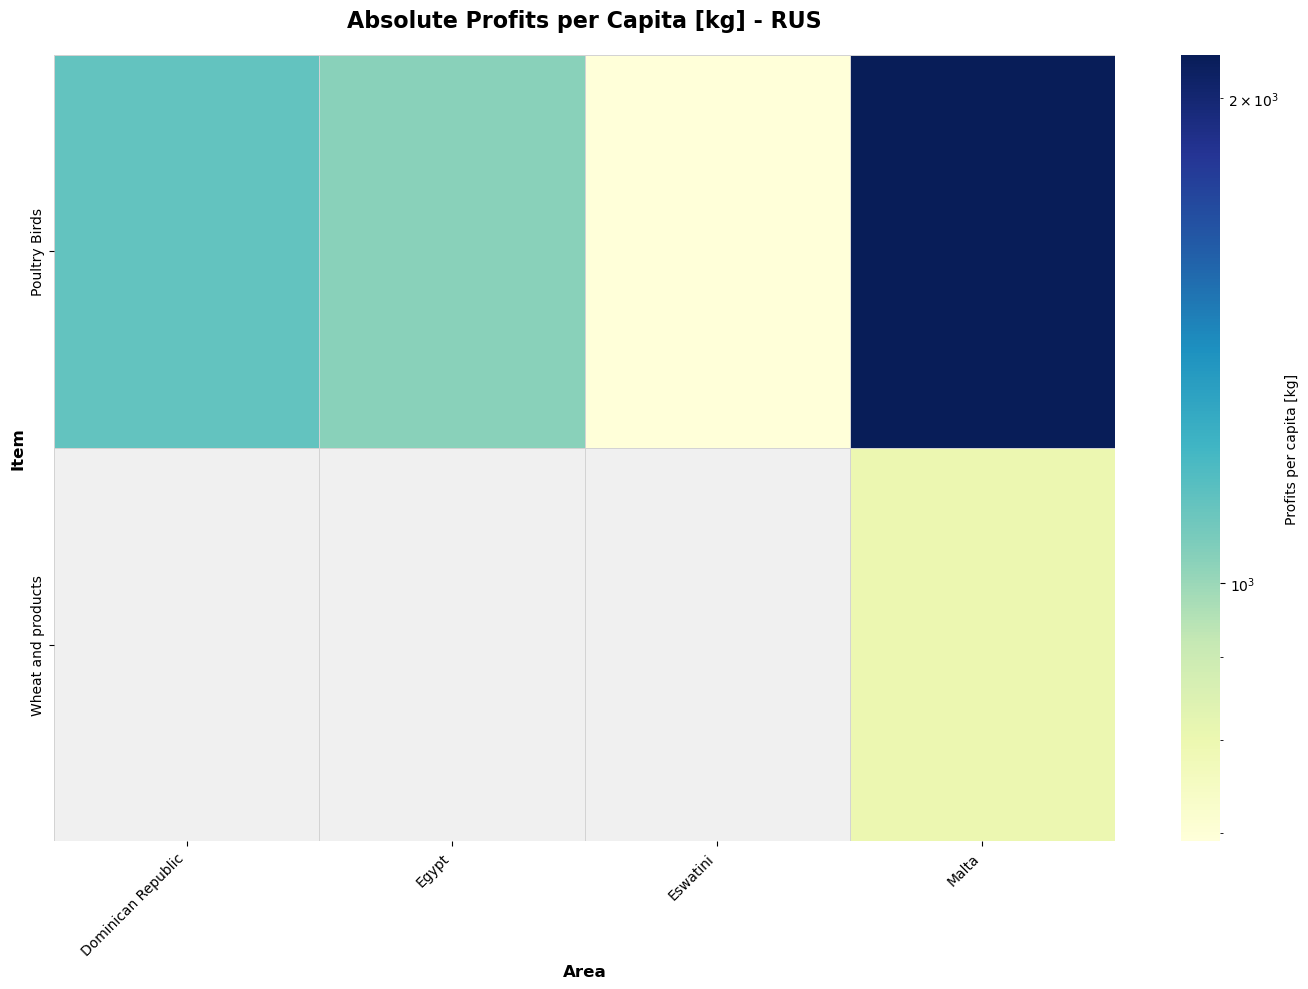

Scenario: HOA, vmin=912.8933838649992, vmax=1746.4529401238972


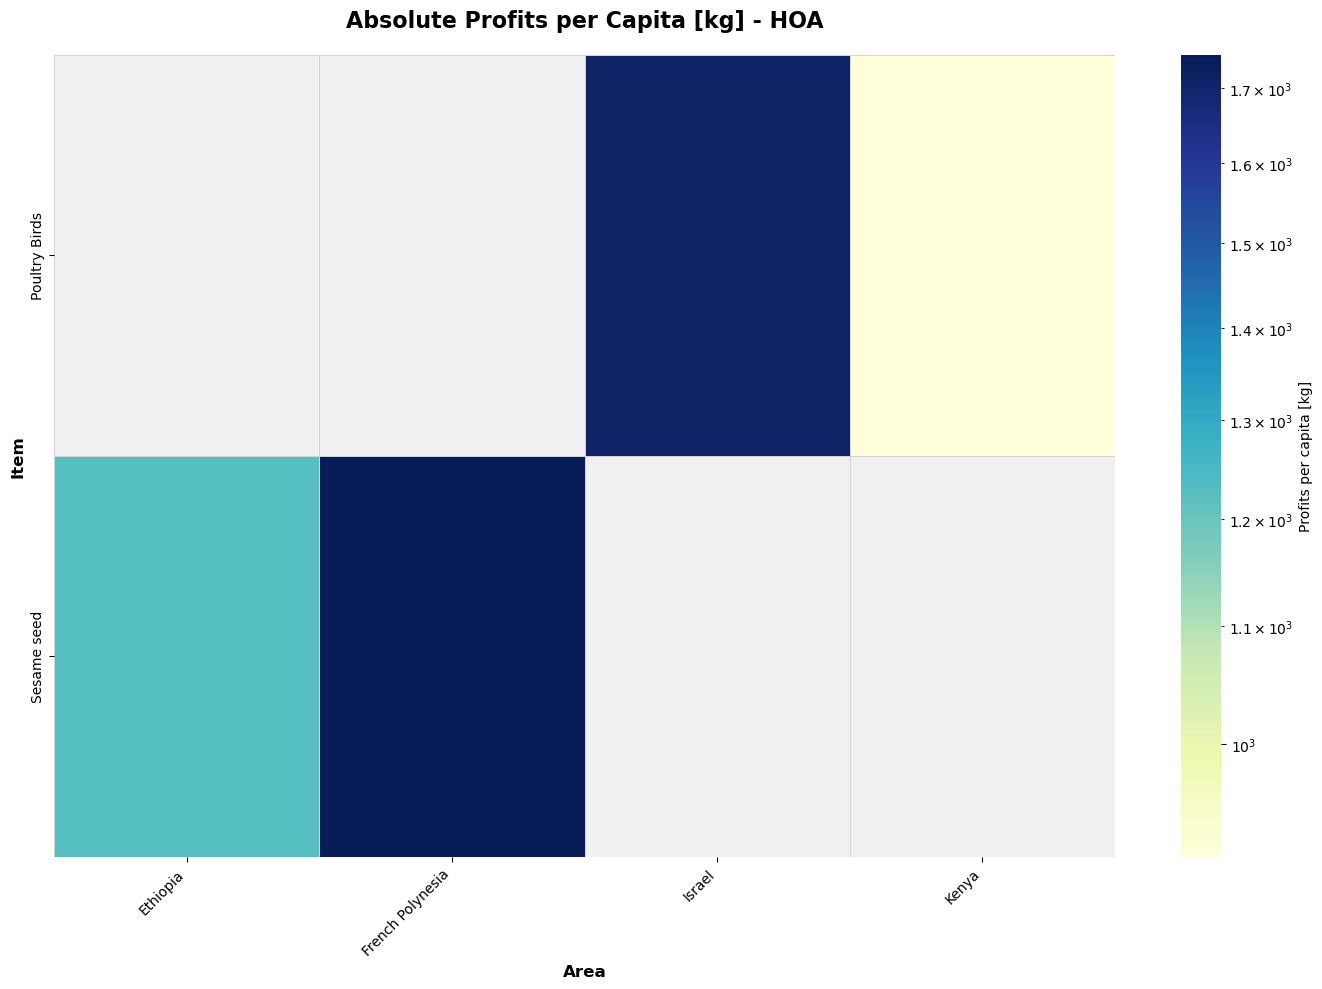

Scenario: URU, vmin=505.59222003536064, vmax=9579348.66904554


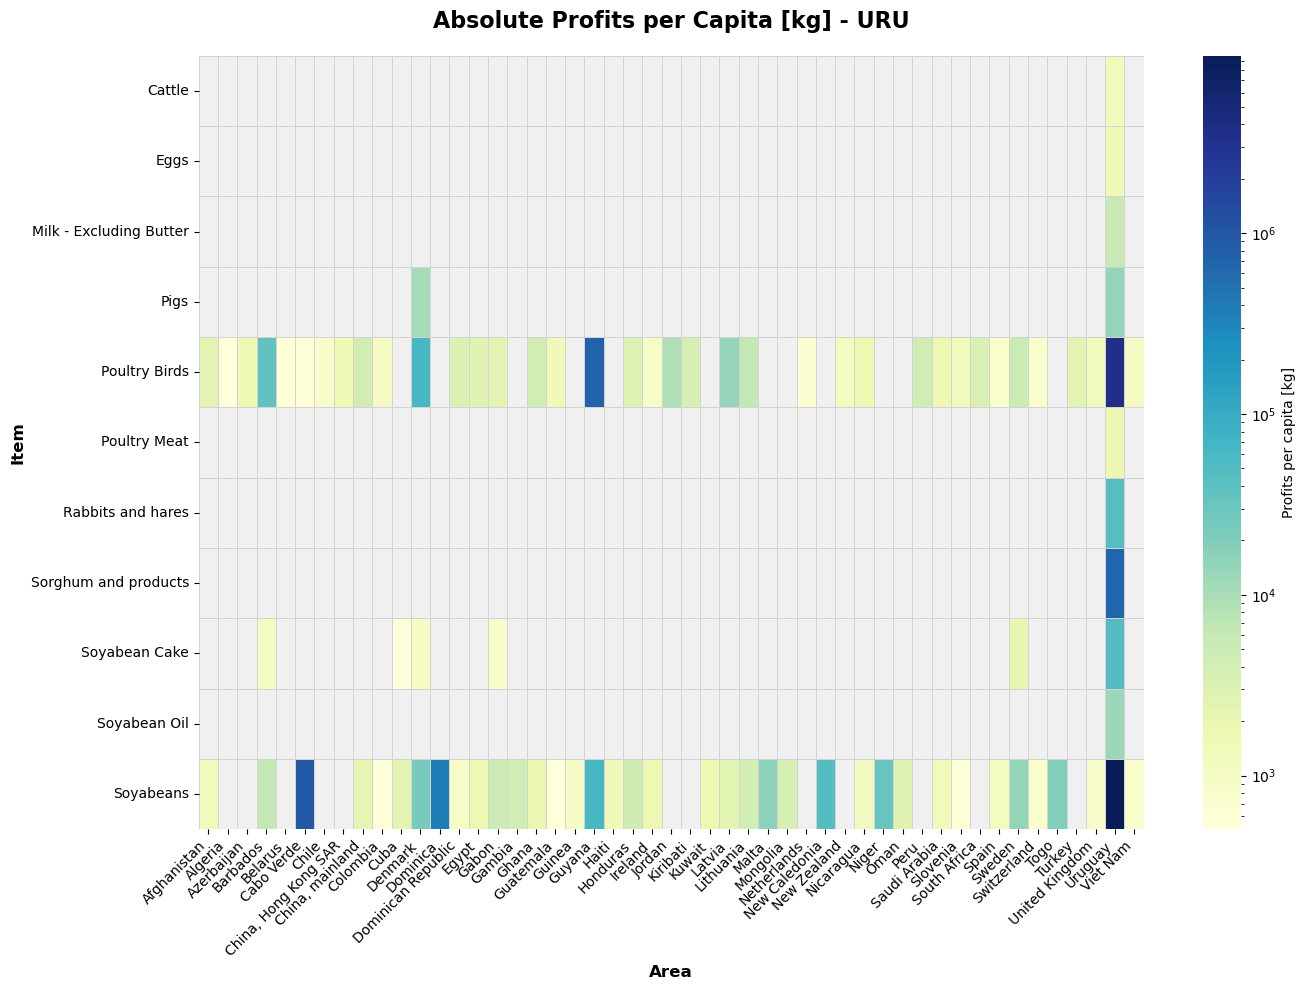

Scenario: ALL, vmin=505.59222003536064, vmax=9579348.66904554


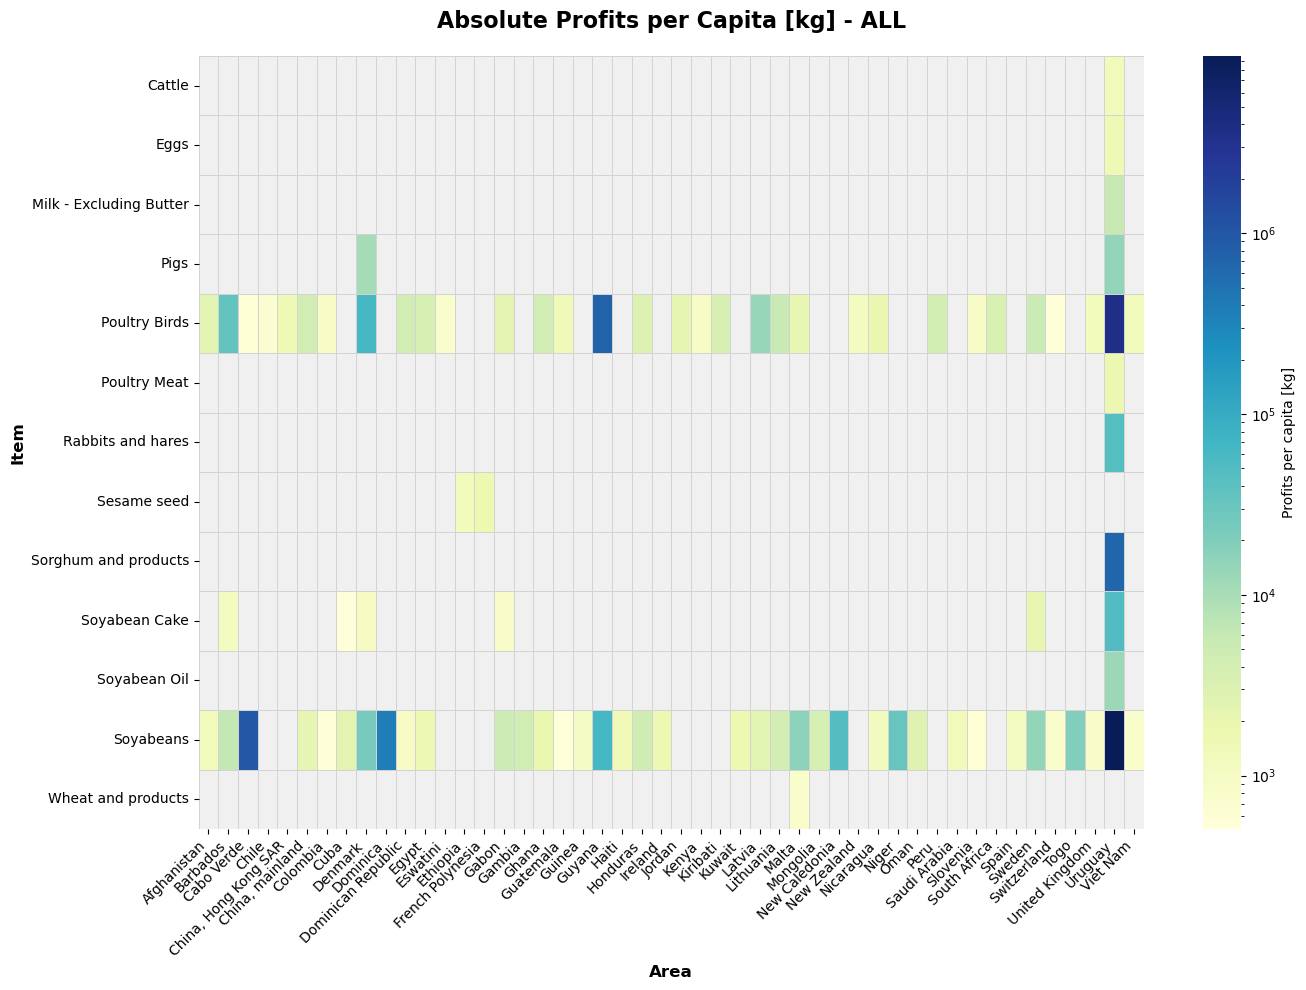

In [9]:
for s in scenario:
    if s not in df:
        print(f"Skipping {s}: no data loaded.")
        continue

    pivot_table = df[s].pivot_table(
        index='item',
        columns='area',
        values='al/capita [kg]',
        aggfunc='sum',
        fill_value=0
    )

    masked_data = pivot_table.replace(0, np.nan).abs()
    
    if masked_data.isna().all().all():
        print(f"Skipping {s}: no valid data to plot.")
        continue

    positive_values = masked_data.values.flatten()
    positive_values = positive_values[~np.isnan(positive_values)]

    if len(positive_values) == 0:
        print(f"Skipping {s}: no positive values found.")
        continue

    vmin = max(positive_values.min(), 1e-3)
    vmax = positive_values.max()
    if vmin >= vmax:
        vmax = vmin * 10

    print(f"Scenario: {s}, vmin={vmin}, vmax={vmax}")

    cmap = plt.colormaps.get_cmap("YlGnBu").copy()
    cmap.set_bad(color='#f0f0f0')  # light gray for NaNs

    plt.figure(figsize=(14, 10))
    ax = sns.heatmap(
        masked_data,
        cmap=cmap,
        norm=LogNorm(vmin=vmin, vmax=vmax),
        linewidths=0.5,
        linecolor='lightgray',
        cbar_kws={"label": "Profits per capita [kg]"},
    )

    ax.set_title(f"Absolute Profits per Capita [kg] - {s}", fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel("Area", fontsize=12, fontweight='bold')
    ax.set_ylabel("Item", fontsize=12, fontweight='bold')

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

    plt.tight_layout()
    filename = f"profits_per_capita_{s.replace(' ', '_')}.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=300)
    plt.show()